In [1]:
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random


### Helper Functions

In [8]:
### Windowing Algorithm
### make sure to be aware of the interchanging of y and x
def window_algorithm(img_sample,window_resolution = 1, threshold=0.5):
    """
    Scans the input picture and detects brightest regions which could be ions
    It performs the scanning through a rectangular filter whose stride can be modified using window_resolution input
    Returns ROI regions enclosed in rectangles
    
    Inputs:
    1. img_sample: openCV frame object (cv2.imread(src,0))
    2. window_resolution : stride of the moving rectangular filter
    3. threshold : threshold for the ratio area occupied by the bright pixels inside rectangle/area of the rectangle
    
    
    Outputs:
    img_copy: Copy of the image with marked rectangular ROI
    box_out : array of coordinates of rectangles corresponding to ROI (x,y)
    
    """
    _,img_thresh = cv2.threshold(img_sample,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #img_sample = img_thresh
    img_copy = img_sample.copy()
    img_sample = img_thresh
    img_shape = img_sample.shape
    window_resolution = window_resolution# higher the resolution more sampling
    window_size = np.array([15,15]) #np.array([img_shape[0]/10,img_shape[1]/10]).astype(int) # size of the square/rect window
    start_coord, end_coord = np.array([0,0]), np.array([img_sample.shape[0],img_sample.shape[1]])
    active_coord = np.array([0,0]) #beginning of the operation
    i=0 # debug parameter
    area_window= window_size[0]*window_size[1] #area of the window box

    box_out = [] #list containing boxes
    while(active_coord[0]<end_coord[0]-window_size[0]):
        while (active_coord[1]<end_coord[1]-window_size[1]):
            middle_coord = [int(active_coord[0] + window_size[0]/2), int(active_coord[1]+window_size[1]/2)] #centroid of rect
            temp= (img_sample[middle_coord[0],middle_coord[1]] == 255).astype(int)
            if temp==1:
                #print('ggg')
                # region occupied by the spot
                white_region = np.argwhere(img_sample[active_coord[0]:active_coord[0] + window_size[0],\
                                                     active_coord[1]:active_coord[1] + window_size[1]] >200)
                # compare the spot size to the area
                if white_region.size/area_window > threshold:
                    #print('white_region_size',white_region.size)
                    #print(active_coord)
                    # mark the spot window
                    cv2.rectangle(img_copy, (active_coord[1],active_coord[0]),(active_coord[1]+window_size[1],active_coord[0] \
                                                                                 +window_size[0]),(255,0,0))
                    # append it to box_out
                    box_out.append([(active_coord[0],active_coord[1]),(active_coord[0]+window_size[0],active_coord[1] \
                                                                                 +window_size[1])])
            # update window horizontally
            active_coord[1] = active_coord[1] + int(window_size[1]/window_resolution)
            #print(i)
            i+=1

        # update window vertically
        active_coord[1] = start_coord[1]
        active_coord[0] = active_coord[0] + int(window_size[1]/window_resolution)


    return img_copy, box_out




   
### Looping Window Algorithm
## Adaptive window resolution
## Doesn't work well, can improve
def window_algorithm_two_boxes(img_sample, threshold=0.5):
    window_resolution_arr = np.arange(1,10,0.5)
    for window_resolution in window_resolution_arr:
        img_out,box_out = window_algorithm(img_sample,window_resolution = window_resolution, threshold=threshold)
        if len(box_out) >= 2:
            break
    return img_out,box_out,window_resolution    


# Arrange the boxes
def box_arrange(box_out):
    """
    Inputs:
    Box_out : box_out output from window_algorithm function
    
    Outputs:
    
    xmax_arr, ymax_arr: array outputs corresponding to x,y coordinates of the rectangular borders
    xmax_avg, ymax_avg : average length and breadth of the rectangular borders
    """
    xmax_arr = []
    ymax_arr = []
    len_arr, breadth_arr = [],[]
    for (i,j),(k,l) in box_out:
        ymax_arr.append(int((i+k)/2))
        xmax_arr.append(int((j+l)/2))
        len_arr.append(np.abs(int(k-i)))
        breadth_arr.append(np.abs(int(l-j)))
        
    xmax_avg = np.mean(breadth_arr)
    ymax_avg = np.mean(len_arr)
        
    return xmax_arr,ymax_arr, xmax_avg, ymax_avg

# function to find masks in a certain ROI
def return_mask(img_crop,threshold=220, noOfPixels=15):
    #img must be ROI
    # noOfPixels denotes max no of pixels in the mask
    #mask_black = np.argwhere((img_crop<threshold))
    mask = np.zeros(img_crop.shape[:2], np.uint8)
    #mask[50:100, 0:170] = 255 #choose ROI y,x 

    mask_white = np.argwhere((img_crop>threshold))[:noOfPixels]
    for i,j in mask_white:
        mask[i,j] = 255
        #plt.imshow(img_crop,cmap='gray')
        #plt.imshow(img_crop,cmap='gray')
    masked_img = cv2.bitwise_and(img_crop,img_crop,mask = mask)    
    return mask_white, masked_img

# use xmax to set ROI
# yrange is fixed
def return_all_masks(img,xmax_arr,ymax_arr,threshold=220):
    """
    Takes in x,y coordinate arrays of the marked ions and returns masks
    
    @Inputs: xmax_arr, ymax_arr
    
    @Returns: 
    
    ions_masks : numpy array of masks with each index corresponding to the ion number
    ions_masks_img: opencv frame object of each mask (only for debug/visualization purposes)
    
    
    """
    
    ylen = 15# y dimension of the mask
    yrange =np.array([np.mean(ymax_arr)-ylen/2,np.mean(ymax_arr)+ylen/2]).astype(int)#[15,40] # CHANGE LATER TO ADAPT TO the box_out window size
    xlen_half = int(np.mean(xmax_arr)/4) # average breadth of the boxes divided by 4
    ions_masks = [] #initialize masks
    ions_masks_img = []
    for x in xmax_arr:
        mask_temp,mask_img = return_mask(img[yrange[0]:yrange[1],x-xlen_half:x+xlen_half],threshold=threshold) #return masks for range [x-5,x+5]
        for i in range(0,mask_temp.shape[0]):
            mask_temp[i][1] += x #rescale x
            mask_temp[i][0] += yrange[0] #rescale y
        if mask_temp.size != 0:
            ions_masks.append(mask_temp) #append masks to list
            ions_masks_img.append(mask_img) #append mask image to list
    return ions_masks,ions_masks_img



### Main Function

#### Returns the masks in raw form

In [9]:
def calib_mask_generate(img,threshold=0.5,window_resolution=1):
    """
    Generates masks from an input image
    
    Inputs: 
    1. img : OpenCV frame(?) object (cv2.imread(src,0))
    
    Outputs:
    1. ions_masks: numpy array of all masks detected
    2. ions_masks_img : array of opencv frame of individual masks
    3. img_copy : Copy of image with the marked boxes (debug only)
    
    
    """
    # window algorithm to mark the ions
    img_copy, box_out = window_algorithm(img,window_resolution = window_resolution, threshold=threshold)
    
    # get the x,y coordinates of the centroids of the marked ions (box_out)
    xmax_arr, ymax_arr,_,_ = box_arrange(box_out)

    # return masks from these x,y
    ions_masks, ions_masks_img = return_all_masks(img,xmax_arr,ymax_arr)
    
    return ions_masks,ions_masks_img,img_copy

#### Order Masks


In [10]:
def rearrange_masks(masks):
    """
    Rearranging the masks obtain from calib_masks_generate() as (x,y,ion_number)
    
    Input:
    1. masks : return object from calib_masks_generate
    
    Outputs:
    calib_sorted_arr: Sorted numpy array of the calibration masks in (x,y,ion number) format
    
    
    
    """
    ### Rearranging masks for thresholding
    ions_masks = np.array(masks)
    no_of_ions = ions_masks.shape[0]
    ions_masked_reshaped=np.array(ions_masks).reshape(no_of_ions,-1,2)
    ions_masked_reshaped_shape = ions_masked_reshaped.shape
  
    ions_masks_numbered = []
    for i in range(0,ions_masked_reshaped_shape[0]):
        for j in range(0,ions_masked_reshaped_shape[1]):
            temp= np.append(ions_masked_reshaped[i,j],i+1)
            ions_masks_numbered.append(tuple(temp))

    ### Create a structure array with x,y, ion_no

    calib_arr_dtype = [('y',int),('x',int),('ion_no',int)]
    st_calib_arr = np.array(ions_masks_numbered,dtype =calib_arr_dtype)

    calib_arr_sorted = np.sort(st_calib_arr,order ='y')
    calib_arr_sorted[1][0]
    
    return calib_arr_sorted

### Testing the function

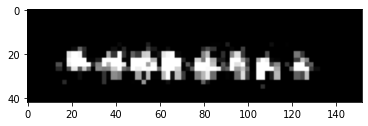

In [29]:
#load Image
src = 'test_image_grayscale.png' #'ions_test_image.jpg'
img = cv2.imread(src,0)
plt.imshow(img,cmap='gray')


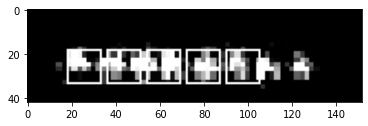

In [80]:
#Run calib_mask_generate
src = 'test_image_grayscale.png'#'ions_test_image.jpg'
img1 = cv2.imread(src,0)
masks,_,img_out = calib_mask_generate(img1,threshold=0.3,window_resolution=0.8)
plt.imshow(img_out,cmap='gray')


#### Rearrange Masks

In [90]:
rearrange_masks(masks)

array([(19,  33, 1), (19,  34, 1), (19,  35, 1), (19,  36, 1),
       (19,  37, 1), (19,  38, 1), (19,  39, 1), (19,  56, 2),
       (19,  57, 2), (19,  76, 3), (19,  77, 3), (19,  78, 3),
       (19,  79, 3), (19,  79, 4), (19,  80, 3), (19,  80, 4),
       (19,  81, 3), (19,  81, 4), (19, 109, 5), (19, 110, 5),
       (19, 111, 5), (20,  33, 1), (20,  34, 1), (20,  35, 1),
       (20,  36, 1), (20,  37, 1), (20,  38, 1), (20,  39, 1),
       (20,  56, 2), (20,  57, 2), (20,  76, 3), (20,  77, 3),
       (20,  78, 3), (20,  79, 3), (20,  79, 4), (20,  80, 3),
       (20,  80, 4), (20,  81, 3), (20,  81, 4), (20, 109, 5),
       (20, 110, 5), (20, 111, 5), (21,  33, 1), (21,  56, 2),
       (21,  57, 2), (21,  76, 3), (21,  77, 3), (21,  78, 3),
       (21,  79, 4), (21,  80, 4), (21,  81, 4), (21, 109, 5),
       (21, 110, 5), (21, 111, 5), (22,  49, 2), (22,  50, 2),
       (22,  51, 2), (22,  52, 2), (22,  53, 2), (22,  54, 2),
       (22,  55, 2), (22,  56, 2), (22,  57, 2), (22,  

### Save in Desired Format for Testbench

The following two functions save the calibration masks and the image pixel data in a certain format commanded by the verilog modules

The image pixels data is used as an input to the testbench verilog module. They are stored as 16 bit numbers in a line by line format. The coordinate of the pixel can be deciphered by looking at the '/' symbol. Each '/' symbol signifies a change in y (i.e, y-> y+1) and each new line corresponds to a change in x


The calibration  masks are stored at single array of 48 bit numbers (16 bit x, 16 bit y and 16 bit ion number)



In [27]:
# save image in the desired format for testbench
def pix_save_testbench(src,filename='pix_data.txt'):
    '''
    src = input image path
    filename = output file path
    
    ''' 
    img = cv2.imread(src,0)
    with open(filename,'w') as fp:
        for i in range(0,img.shape[0]):
            fp.write('/\n')
            for j in range(0,img.shape[1]):
                fp.write(str(img[i,j])+'\n')
        fp.write('-\n')


In [30]:
# write masks to file as 48 bit numbers
def save_calib_sorted_file(calib_arr_sorted,fname = 'calibration_sorted_coord.txt'):
    file_name = fname
    with open(file_name,"w") as fp:
        for i in range(0,len(calib_arr_sorted)):
            print(calib_arr_sorted[i])
            j,k,l = calib_arr_sorted[i]
            y_bin = f"{j+1:016b}" #sub 1 to y  to match the verilog convention 
            x_bin = f"{k+1:016b}" # sub 1 to x
            ion_no = f"{l:016b}"
            fp.write(x_bin)
            fp.write(" ")
            fp.write(str(y_bin)+' ')
            fp.write(str(ion_no)+' ')
            
            


### Test 

In [ ]:
src = 'test_image_grayscale.png'
image = cv2.imread(src,0)
## get the masks from the algorithm
masks1,mask_img,img_copy = calib_mask_generate(img=image,threshold=0.5,window_resolution=0.7)

## rearramge the masks acc to ion number
calib_arr_sorted = rearrange_masks(masks1)

## save the masks and the picel data
save_calib_sorted_file(calib_arr_sorted)
pix_save_testbench(src)

### Testing for different Threshold

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

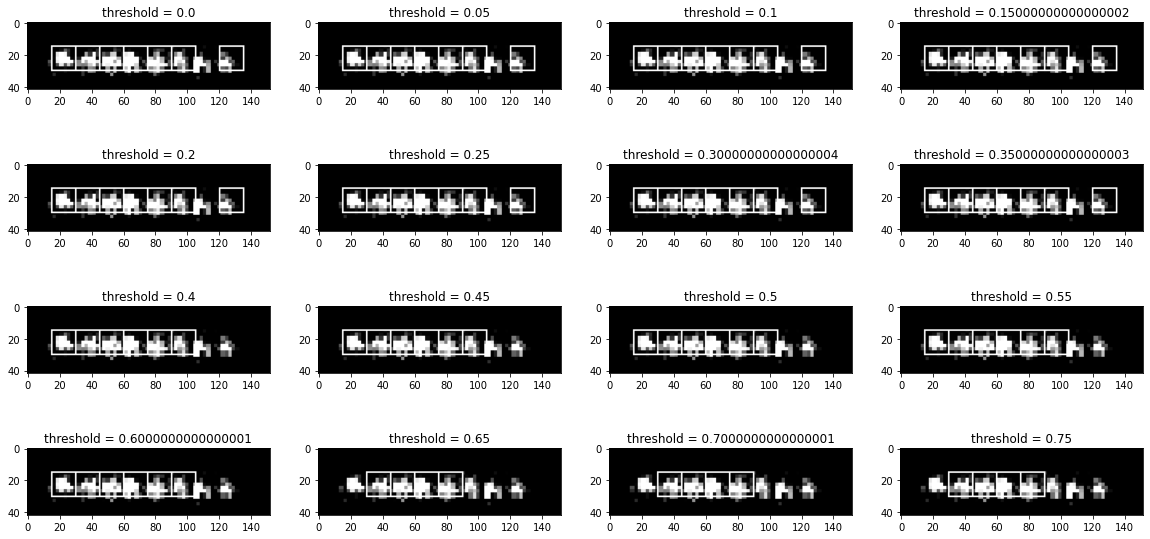

In [113]:
threshold = np.arange(0,0.8,0.05)
threshold = threshold.reshape(4,-1)
row,col = threshold.shape
window_resolution = 1
src = 'test_image_grayscale.png'#'ions_test_image.jpg'
img = cv2.imread(src,0) 
res = []
fig,ax = plt.subplots(row,col,figsize=(20,10))
no_of_ions = 8
accuracy = []
for i in range(0,row):
    for j in range(0,threshold.shape[1]):
        res=calib_mask_generate(img,threshold=threshold[i,j],window_resolution=window_resolution)
        ax[i,j].imshow(res[2],cmap='gray')
        title = 'threshold = ' + str(threshold[i,j])
        ax[i,j].set_title(title)
        accuracy.append(len(res[0])/no_of_ions)

#plt accuracy


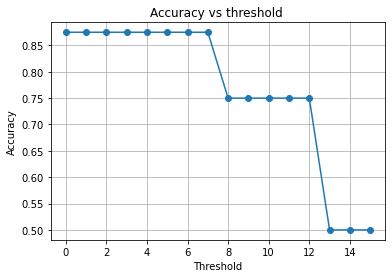

In [114]:
plt.plot(np.arange(len(accuracy)),accuracy,'-o')
plt.title('Accuracy vs threshold ')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.grid()
plt.show()


### Testing for different Window Steps


5
6
8
10
24
30
39
39
79
79


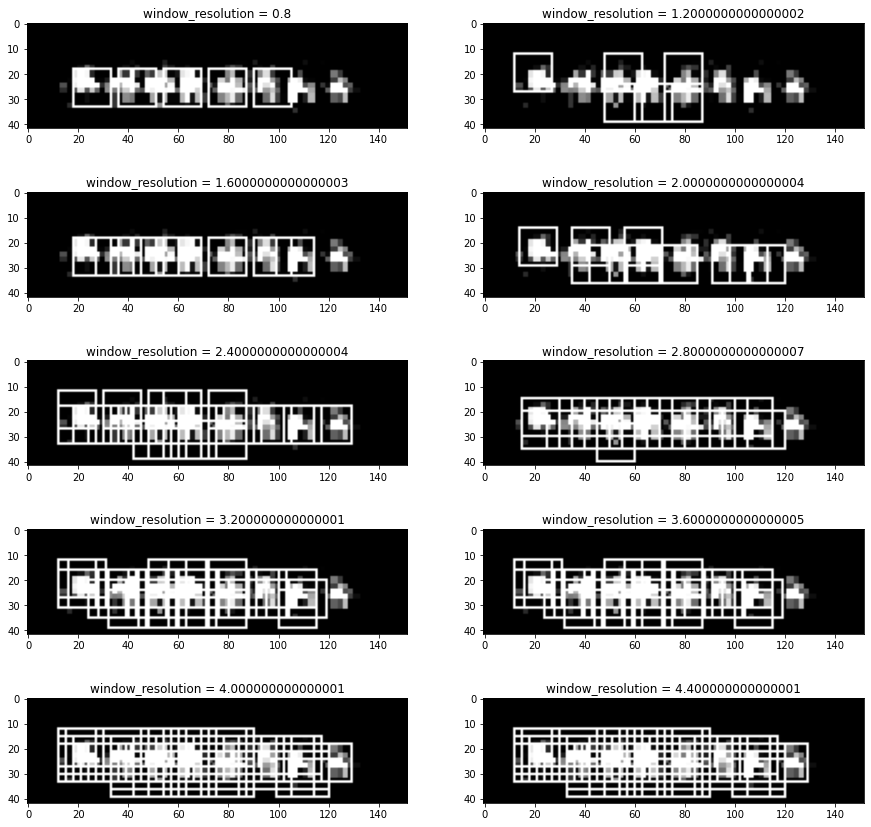

In [105]:
window_resolution = np.arange(0.8,4.8,0.4)
window_resolution = window_resolution.reshape(5,-1)
threshold = 0.5
row,col = window_resolution.shape
src = 'test_image_grayscale.png'#'ions_test_image.jpg'
img = cv2.imread(src,0) 
res = []
fig,ax = plt.subplots(row,col,figsize=(15,15))
no_of_ions = 8
accuracy = []
for i in range(0,row):
    for j in range(0,window_resolution.shape[1]):
        res=calib_mask_generate(img,threshold=threshold,window_resolution=window_resolution[i,j])
        ax[i,j].imshow(res[2],cmap='gray')
        title = 'window_resolution = ' + str(window_resolution[i,j])
        ax[i,j].set_title(title)
        if len(res[0])>8:
            accuracy.append(0)
            print(len(res[0]))
        else:
            print(len(res[0]))
            accuracy.append(len(res[0])/no_of_ions)

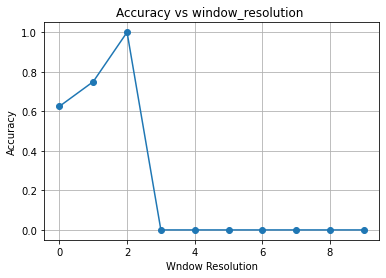

In [111]:
plt.plot(np.arange(len(accuracy)),accuracy,'-o')
plt.title('Accuracy vs window_resolution ')
plt.xlabel('Wndow Resolution')
plt.ylabel('Accuracy')
plt.grid()
plt.show()
